# Import the libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Split the Independent and Dependent Features

In [7]:
features = ['battery_power', 'int_memory', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
X_train = train[features]
y_train = train['price_range']
X_test = test[features]

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=0)


Create a dictionary for 4 models to train simulataneously

In [8]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=100, random_state=0),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=0),
    'Support Vector Classifier': SVC(C=42,random_state=0,kernel='poly',degree=2),
}

# Initialize results dictionary
results = {}

# Train and evaluate models
for name, clf in models.items():
    # Fit the model
    clf.fit(X_train_split, y_train_split)

    # Predict on validation set
    y_pred = clf.predict(X_val_split)

    # Evaluate model
    accuracy = accuracy_score(y_val_split, y_pred)
    report = classification_report(y_val_split, y_pred, output_dict=True)

    # Extract metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

    # Store results
    results[name] = metrics

# Convert results to DataFrame
result = pd.DataFrame(results).T

# Sort by a specific metric (e.g., Accuracy) from highest to lowest
sorted_result = result.sort_values(by='Accuracy', ascending=False)


c:\Users\lalit\Documents\Machine Learning\assignments\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
sorted_result

,Accuracy,Precision,Recall,F1-Score
Support Vector Classifier,0.9675,0.968051,0.9675,0.967639
Random Forest,0.8850,0.883693,0.8850,0.884088
Decision Tree,0.8400,0.839596,0.8400,0.839787
Logistic Regression,0.6525,0.649673,0.6525,0.650905


Plot the model's accuracy to pick the best one

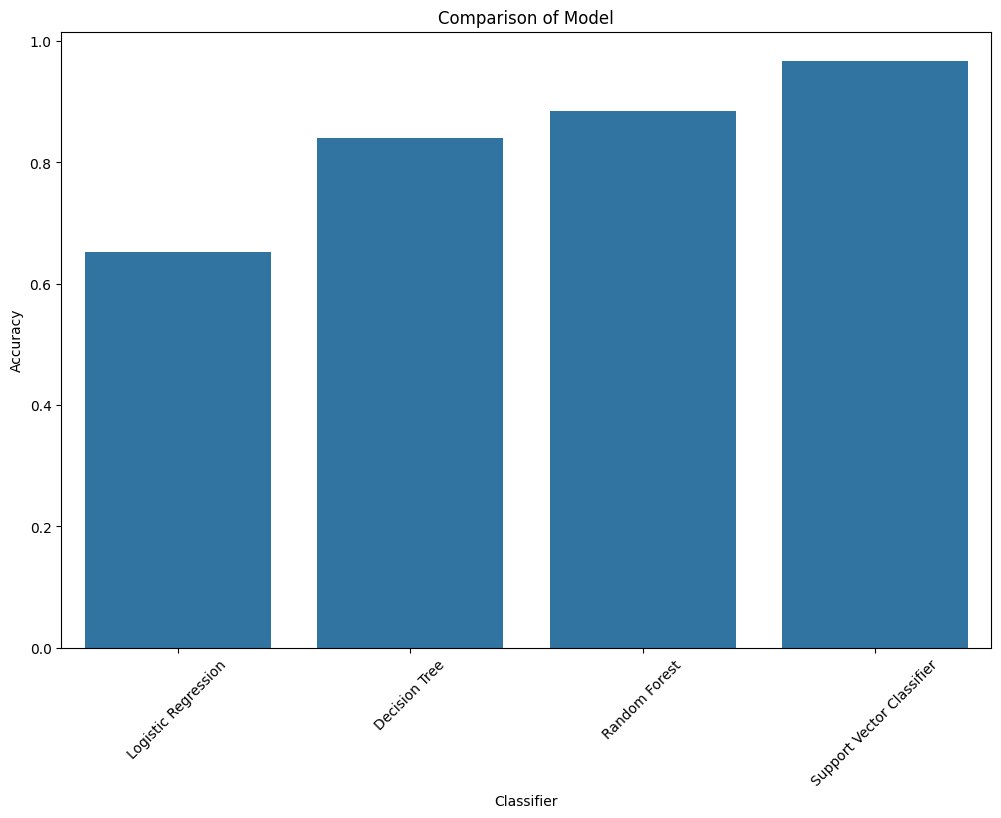

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(x=result.index, y=result['Accuracy'])
plt.title('Comparison of Model')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

SVC Algorithm have 96% accuracy on the training data

# Hyper Parameter Tuning

We'll continue with the Hyper Parameter tuning using the GridSearchCV with the same models and see if SVC beats them.

We use a pipeline with the parameters to train the Grid model and pick out the Best Model, params and score

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC())
])

# Define the parameter grid
param_grid = [
    {
        'classifier': [LogisticRegression()],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__kernel': ['rbf', 'linear'],
        'classifier__gamma': ['scale', 'auto']
    },
    {
        'classifier': [DecisionTreeClassifier()],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    }
]

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV
grid_search.fit(X_train_split, y_train_split)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_val_split, y_val_split)
print("Test set accuracy with best model:", accuracy)

Fitting 5 folds for each of 88 candidates, totalling 440 fits
Best parameters: {'classifier': LogisticRegression(), 'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best cross-validation score: 0.974375
Test set accuracy with best model: 0.975


c:\Users\lalit\Documents\Machine Learning\assignments\.venv\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Interpretation:

1. The Logistic Regression model outperformed the other models (SVC, Decision Tree, and Random Forest) for this particular dataset.
2. The model shows consistent performance between cross-validation (97.4375%) and the test set (97.5%), which suggests it generalizes well and is not overfitting.
3. The L1 penalty (Lasso regularization) was selected, which can help with feature selection by setting some coefficients to zero.
4. The high accuracy suggests that this is a relatively easy classification problem, or that the features are highly informative.
5. Evaluate the other metrics like Precision, Recall, F1 score, confusion matrix to get aclear idea about the model

In [12]:
y_pred = best_model.predict(X_val_split)
print(classification_report(y_val_split, y_pred))
print(confusion_matrix(y_val_split, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        95
           1       0.95      0.98      0.96        92
           2       0.98      0.95      0.96        99
           3       0.99      0.98      0.99       114

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.98      0.97      0.98       400

[[ 94   1   0   0]
 [  2  90   0   0]
 [  0   4  94   1]
 [  0   0   2 112]]


Plot learning curves to see if you could benefit from more data or if you're overfitting/underfitting.

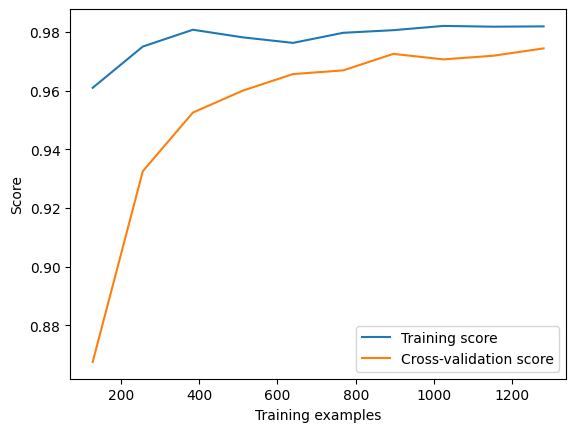

In [13]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_split, y_train_split, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()

Now it's time for Deployment, so export the model in pickle format

We use StandardScaler as a part of our best model, so don't forget to export the scaler model.

This will be automatically used when you predict witht he new data

In [14]:
import pickle
pickle.dump(StandardScaler, open('scaler_model.pkl', 'wb'))
pickle.dump(best_model, open('model.pkl', 'wb'))

In [16]:
loaded_model = pickle.load(open('model.pkl', 'rb'))
result = loaded_model.score(X_val_split, y_val_split)
print(result)

0.975


In [24]:
loaded_model.predict(X_val_split)

array([3, 0, 2, 2, 2, 0, 0, 3, 3, 1, 1, 3, 0, 2, 3, 0, 3, 2, 2, 1, 0, 0,
       3, 1, 2, 2, 3, 1, 3, 1, 1, 0, 2, 0, 1, 3, 0, 0, 3, 3, 3, 1, 3, 3,
       1, 3, 0, 1, 3, 1, 1, 3, 0, 3, 0, 2, 2, 2, 0, 3, 3, 1, 3, 2, 1, 2,
       3, 2, 2, 2, 3, 2, 1, 0, 1, 3, 2, 2, 1, 2, 3, 3, 3, 0, 0, 0, 2, 1,
       2, 3, 1, 2, 2, 1, 0, 3, 3, 3, 0, 3, 1, 1, 2, 1, 3, 2, 2, 3, 2, 3,
       3, 0, 0, 1, 3, 3, 0, 0, 1, 0, 0, 3, 2, 2, 1, 1, 1, 1, 0, 2, 1, 3,
       3, 3, 3, 3, 3, 2, 0, 1, 1, 2, 1, 3, 0, 3, 0, 0, 2, 0, 1, 1, 1, 1,
       3, 0, 0, 3, 1, 3, 2, 1, 3, 1, 2, 3, 3, 2, 1, 0, 3, 1, 2, 3, 3, 0,
       2, 2, 3, 0, 2, 1, 0, 1, 2, 1, 2, 0, 3, 3, 1, 1, 0, 2, 3, 0, 1, 2,
       2, 0, 3, 3, 3, 1, 2, 3, 3, 3, 0, 0, 0, 2, 3, 3, 0, 0, 1, 3, 1, 3,
       3, 3, 0, 0, 2, 2, 3, 1, 0, 2, 0, 0, 0, 3, 2, 1, 2, 2, 1, 1, 0, 2,
       3, 3, 0, 0, 1, 3, 3, 2, 3, 0, 3, 1, 1, 0, 2, 3, 3, 2, 0, 0, 1, 2,
       3, 2, 2, 3, 1, 1, 0, 3, 3, 2, 1, 3, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0,
       2, 2, 2, 2, 0, 1, 3, 0, 1, 2, 3, 0, 2, 0, 1,